# Stock Prediction using RNN

## Introduction
### RNN
A recurrent neural network (RNN) is a class of artificial neural network where connections between nodes form a directed graph along a sequence. This allows it to exhibit temporal dynamic behavior for a time sequence. Unlike feedforward neural networks, RNNs can use their internal state (memory) to process sequences of inputs.

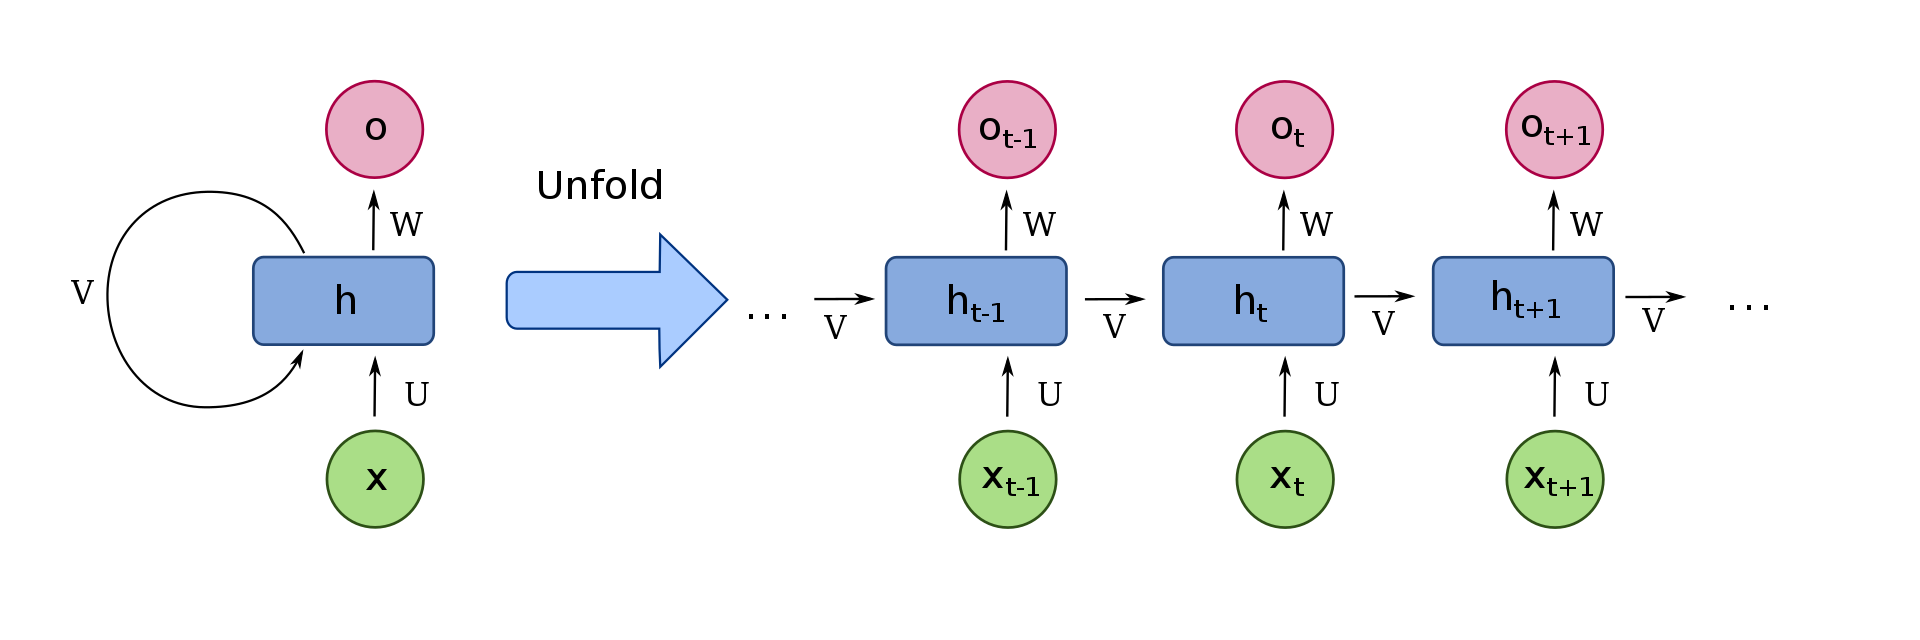

In [1]:
from IPython.display import Image
Image(filename='Recurrent_neural_network_unfold.png')

### LSTM
Long short-term memory (LSTM) is a deep learning system that avoids the vanishing gradient problem. LSTM is normally augmented by recurrent gates called "forget" gates. LSTM prevents backpropagated errors from vanishing or exploding. Instead, errors can flow backwards through unlimited numbers of virtual layers unfolded in space. That is, LSTM can learn tasks that require memories of events that happened thousands or even millions of discrete time steps earlier. Problem-specific LSTM-like topologies can be evolved. LSTM works even given long delays between significant events and can handle signals that mix low and high frequency components.

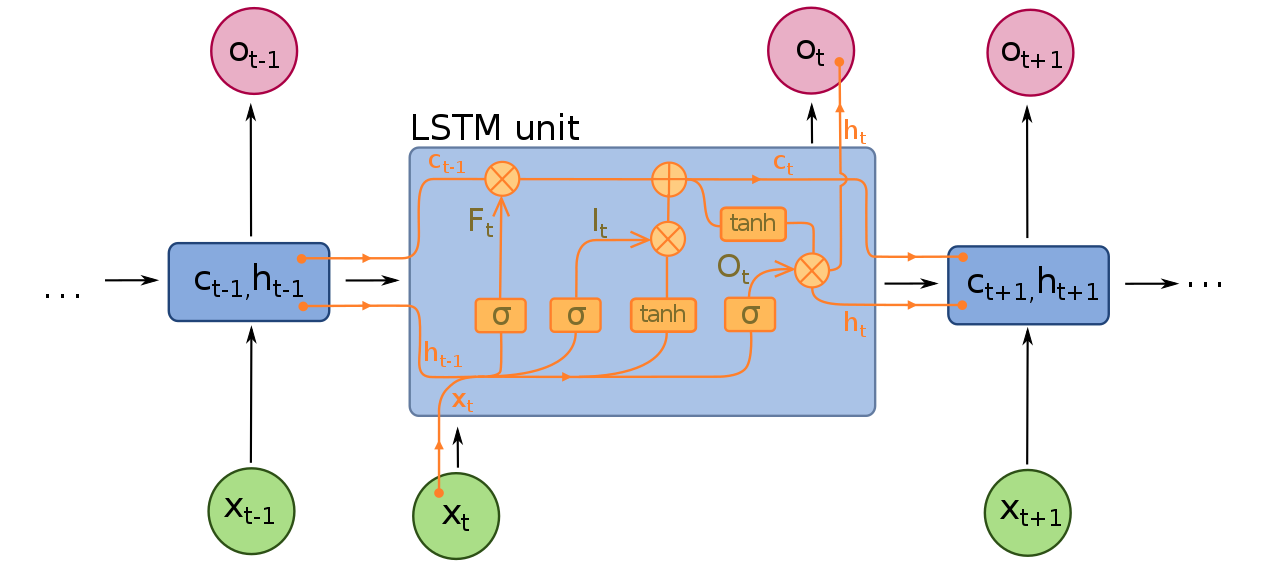

In [2]:
Image(filename='Long_Short-Term_Memory.png')

## Aim
In this notebook, we will predict the value of any stock for the past three weeks using a Recurrent Neural Network using the following steps ->
1. Data Preprocessing
2. Building the RNN
3. Making the predictions
4. Visualising the result

## Step 1 - Data Preprocessing
#### Importing the libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import plotly.offline as pyo

# For Notebooks
pyo.init_notebook_mode(connected=True)

#### Stock Name

In [4]:
stock = input('Stock -> ')

Stock -> GOOGL


#### Downloading the data

In [5]:
start = dt.datetime.today() - dt.timedelta(5*365)
end = dt.datetime.today() - dt.timedelta(21)
dataset_train = web.DataReader(stock, 'yahoo', start, end, retry_count=10)

#### Visualising the data

In [6]:
pyo.iplot([{
    'x': dataset_train.index,
    'y': dataset_train['Open'],
    'name': 'Training Set'
}])

#### Creating the training set

In [7]:
training_set = dataset_train['Open'].values.reshape((-1, 1))

#### Feature Scaling

In [8]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

#### Creating a data structure with 60 timesteps and 1 output

In [9]:
X_train = []
y_train = []
for i in range(60, len(dataset_train)):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

#### Reshaping

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

## Step 2 - Building the RNN
#### Importing the Keras libraries and packages

In [11]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


#### Initialising the RNN

In [12]:
regressor = Sequential()

#### Adding the LSTM layers with Dropout regularisation

In [13]:
# Layer 1
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))

# Layer 2
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Layer 3
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))

# Layer 4
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))

#### Adding the output layer

In [14]:
regressor.add(Dense(units = 1))

#### Compiling the RNN

In [15]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

#### Fitting the RNN to the Training set

In [16]:
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
1185/1185 [==============================] - 7s 6ms/step - loss: 0.0330
Epoch 2/100
1185/1185 [==============================] - 7s 6ms/step - loss: 0.0051
Epoch 3/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0038
Epoch 4/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0036
Epoch 5/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0036
Epoch 6/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0037
Epoch 7/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0044
Epoch 8/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0035
Epoch 9/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0041
Epoch 10/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0036
Epoch 11/100
1185/1185 [==============================] - 5s 4ms/step - loss: 0.0029
Epoch 12/100
1185/1185 [==============================] - 5s 4ms/step - lo

## Part 3 - Making the predictions
#### Getting the real stock price of the last three weeks

In [17]:
dataset_test = web.DataReader(stock, 'yahoo', end, dt.datetime.today(), retry_count=10)
real_stock_price = dataset_test['Open'].values.reshape((-1, 1))

#### Getting the predicted stock price of the last three weeks

In [18]:
dataset_total = pd.concat((dataset_train['Open'], dataset_test['Open']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []
for i in range(60, 60+len(dataset_test)):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

#### Creating the DataFrame

In [19]:
data = {str('Real ' + stock + ' Stock Price'): list(map(lambda x: x[0], real_stock_price.tolist())),
        str('Predicted ' + stock + ' Stock Price'): list(map(lambda x: x[0], predicted_stock_price.tolist()))}
result = pd.DataFrame(data, index=dataset_test.index)

#### Visualising the result

In [20]:
pyo.iplot([{
    'x': result.index,
    'y': result[col],
    'name' : col
} for col in result.columns])

In [21]:
pyo.plot([{
    'x': result.index,
    'y': result[col],
    'name' : col
} for col in result.columns], filename='Predictions/' + stock + ' Prediction.html')

'file:///home/ron/Stock Prediction/Predictions/GOOGL Prediction.html'